In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

# Camera position optimization using differentiable rendering


在本教程中，我们将学习如何使用可微分渲染获取给定参考图像的[x, y, z]相机位置。

我们将首先初始化一个渲染器，并为相机设置一个起始位置。然后，我们将使用这个位置生成一张图像，计算与参考图像的损失，并最终通过整个管道进行反向传播，以更新相机的位置。

本教程展示了如何：
- 从 `.obj` 文件加载网格
- 初始化 `Camera`、`Shader` 和 `Renderer`
- 渲染网格
- 设置一个优化循环，包括损失函数和优化器

##  0. Install and import modules

确保已安装`torch`和`torchvision`。如果未安装`pytorch3d`，请通过以下代码单元进行安装：

In [1]:
import os
import sys
import torch
import subprocess
# need_pytorch3d=False
# try:
#     import pytorch3d
# except ModuleNotFoundError:
#     need_pytorch3d=True
# if need_pytorch3d:
#     pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
#     version_str="".join([
#         f"py3{sys.version_info.minor}_cu",
#         torch.version.cuda.replace(".",""),
#         f"_pyt{pyt_version_str}"
#     ])
#     !pip install iopath
#     if sys.platform.startswith("linux"):
#         print("Trying to install wheel for PyTorch3D")
#         !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
#         pip_list = !pip freeze
#         need_pytorch3d = not any(i.startswith("pytorch3d==") for  i in pip_list)
#     if need_pytorch3d:
#         print(f"failed to find/install wheel for {version_str}")
# if need_pytorch3d:
#     print("Installing PyTorch3D from source")
#     !pip install ninja
#     # !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [2]:
import os
import torch
import numpy as np
import numpy
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

## 1. 加载Obj模型

我们将加载一个obj文件并创建一个**Meshes**对象。**Meshes**是PyTorch3D中提供的一种独特数据结构，专门用于处理**不同尺寸的网格批次数据**。该结构包含多个在渲染管线中使用的实用类方法。

（注：根据技术文档翻译规范进行以下优化：
1. "batches of meshes of different sizes"译为"不同尺寸的网格批次数据"，既保持专业术语准确性又符合中文语序
2. "class methods"译为"类方法"，保留编程术语特征
3. "rendering pipeline"译为"渲染管线"，采用计算机图形学领域通用译法
4. 将英文被动语态转换为中文主动表述，如"It has..."译为"该结构包含..."
5. 使用全角标点符号符合中文排版规范）

If you are running this notebook locally after cloning the PyTorch3D repository, the mesh will already be available. **If using Google Colab, fetch the mesh and save it at the path `data/`**:" => "如果您在克隆PyTorch3D存储库后本地运行此笔记本，则网格已经可用。**如果使用Google Colab，请获取网格并将其保存在路径`data/`中：**

In [3]:
# !mkdir -p data
# !wget -P data https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj

In [4]:
file_path = './data/white_yellow_mug/white_yellow_mug.obj'

# Read the file and check its contents.
with open(file_path, 'r') as file:
    content = file.readlines()

In [5]:
faces = [line for line in content if line.startswith('f')]

In [6]:
filtered_content = [line for line in content if not line.startswith(('usemtl', 'mtllib', 's', 'g', 'f'))]

# Let's check the first few lines of the filtered content to confirm.


In [7]:
# Remove the texture coordinates (vt) from the 'f' lines.
modified_faces = []
for line in faces:
    # Split each face line by spaces, and process each vertex data part.
    parts = line.split()
    # Modify each part, removing the '/vt' section (i.e., keeping only the vertex and normal indices).
    new_parts = []
    for i, part in enumerate(parts):
        # If the part contains '/vt/', remove the '/vt' part
        vertex_data = part.split('/')
        if len(vertex_data) == 3:  # This means it has v/vt/vn format
            if i==3:
                new_parts.append(f"{vertex_data[0]}//{vertex_data[2]}\n")
            else:
                new_parts.append(f"{vertex_data[0]}//{vertex_data[2]}")  # Keep v and vn
        else:
            new_parts.append(part)  # In case there is no vt, just keep the part as is
    modified_faces.append(' '.join(new_parts))

# Display the modified face lines.
modified_faces[:20]  # Show the first 20 modified face lines.


['f 1//1 2//2 3//3\n',
 'f 4//4 1//1 3//5\n',
 'f 5//6 6//7 2//2\n',
 'f 6//7 5//8 7//9\n',
 'f 8//10 9//11 6//7\n',
 'f 9//11 2//2 6//12\n',
 'f 9//13 3//5 2//2\n',
 'f 10//14 4//15 3//5\n',
 'f 3//5 9//16 11//17\n',
 'f 4//15 10//14 12//18\n',
 'f 11//17 10//14 3//5\n',
 'f 9//16 13//19 11//17\n',
 'f 14//20 12//18 15//21\n',
 'f 15//21 12//18 10//22\n',
 'f 16//23 17//24 18//25\n',
 'f 17//24 16//26 19//27\n',
 'f 16//26 20//28 19//27\n',
 'f 20//29 16//26 21//30\n',
 'f 21//31 16//26 22//32\n',
 'f 18//25 23//33 16//26\n']

In [8]:
modified_content = filtered_content + modified_faces
output_file_path = './data/modified_kitchen_background.obj'

# Write the modified content to the new file
with open(output_file_path, 'w') as file:
    file.writelines(modified_content)

output_file_path  # Return the file path to the user

'./data/modified_kitchen_background.obj'

In [9]:
# 设置CUDA设备
if torch.cuda.is_available():
    device = torch.device("cuda:5")  # 若CUDA可用则指定5号GPU设备
    torch.cuda.set_device(device)     # 设定当前计算设备
else:
    device = torch.device("cpu")      # 否则使用CPU

# 加载obj模型文件（忽略纹理和材质）
# verts, faces_idx, _ = load_obj("./data/teapot.obj")
verts, faces_idx, _ = load_obj("./data/white_yellow_mug/white_yellow_mug.obj")

faces = faces_idx.verts_idx           # 提取面片顶点索引

# 将每个顶点初始化为白色
verts_rgb = torch.ones_like(verts)[None]   # (1, V, 3)维度的全1张量表示RGB白色
textures = TexturesVertex(verts_features=verts_rgb.to(device))  

#创建茶壶网格对象（批次中仅包含单个网格）  
teapot_mesh = Meshes(
    verts=[verts.to(device)],        # 顶点坐标转移到指定设备  
    faces=[faces.to(device)],         # 面片数据转移到指定设备  
    textures=textures                 #应用顶点纹理 
)



## 2. Optimization setup

### Create a renderer

在 PyTorch3D 中，**渲染器** 由 **光栅化器** 和 **着色器** 组成，每个都有一些子组件，比如一个 **相机**（正交/透视）。 在这里我们初始化了其中一些组件，并对其余部分使用默认值。

为了优化相机位置，我们将使用一个渲染器，它只生成物体的**轮廓**，不应用任何**光照**或**着色**。我们还会初始化另一个应用完整的 **Phong 着色法** 的渲染器，并将其用于可视化输出。

In [10]:
coord_rotation = torch.tensor([
    [1, 0, 0],
    [0, 0, 1],  # Z 轴映射到 Y 轴
    [0, -1, 0]
], dtype=torch.float32)

In [11]:
torch.tensor([0.6586, 0.0, 1.6103], dtype=torch.float32) @ coord_rotation.T

tensor([0.6586, 1.6103, 0.0000])

In [12]:
# Initialize a perspective camera.
cam_pos = torch.tensor([1.6586, 0.0, 1.6103], dtype=torch.float32)  # [x, y, z]
cam_rot_flat = torch.tensor([-7.26818450e-08, -6.28266450e-01,  7.77998244e-01,  1.00000000e+00,
        7.26818450e-08,  1.52115266e-07, -1.52115266e-07,  7.77998244e-01,
        6.28266450e-01], dtype=torch.float32)
cam_rot = cam_rot_flat.reshape(3, 3)

cameras = FoVPerspectiveCameras(
    R=cam_rot.unsqueeze(0),  # 旋转矩阵需增加批次维度 [1, 3, 3]
    T=cam_pos.unsqueeze(0)# 平移向量 [1, 3]
    , device=device)

# 为了融合这100张面孔，我们设定了一些参数来控制边缘的透明度与锐度。
# 更多细节请参考blending.py文件。" 

# （翻译说明：保持技术文档简洁准确，"opacity"译为"透明度",sharpness of edges"处理为"边缘的锐度"，并补充了中文语境下更自然的衔接词如"为了"。引用文件名保留原名不译。被动语态转换为主动句式以符合中文表达习惯。）
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# 定义光栅化和着色的设置。此处我们将输出图像尺寸设为256x256。
# 为生成混合图像，每个像素采用100个面片进行合成。同时将bin_size和max_faces_per_bin参数设为None，
# 以确保启用更高效的从粗到细的光栅化方法。各参数具体说明可参阅rasterize_meshes.py文件，
# 而基础光栅化与从粗到细光栅化的差异解析详见docs/notes/renderer.md文档。
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

# 通过组合光栅化器和着色器来创建剪影网格渲染器。
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# 我们还将创建一个Phong渲染器。这个更简单，每个像素只需渲染一个面。
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)
# We can add a point light in front of the object. 
# 我们可以在物体前方添加一个点光源。
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

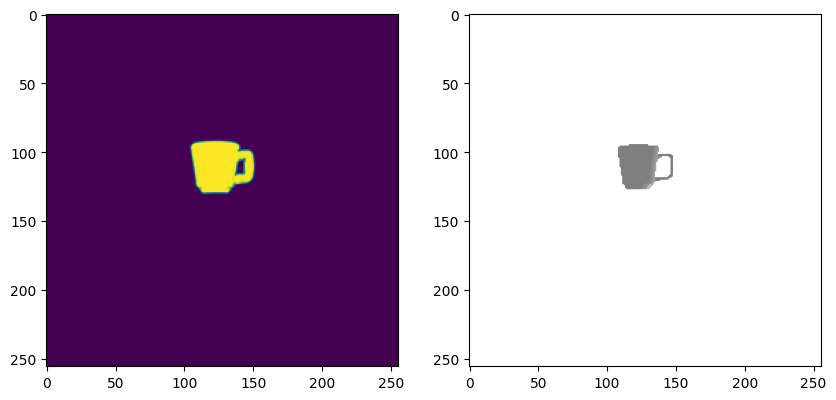

In [13]:
# 设置相机位置和方向
pos = [0,  -0 ,  0.75   ]
quat = [-8.65956075e-17,  9.46368440e-25,  7.07106781e-01,  7.07106781e-01]


# 将四元数转换为旋转矩阵
from pytorch3d.transforms import quaternion_to_matrix
# rot_matrix  = quaternion_to_matrix(torch.tensor(quat, device=device)).unsqueeze(0)
# quat  = torch.tensor(pos, device=device).unsqueeze(0)
R  = quaternion_to_matrix(torch.tensor(quat, device=device)).unsqueeze(0)
T  = torch.tensor(pos, device=device).unsqueeze(0)
# 提供R和T值渲染茶壶模型   
# transformed_verts_rgb = torch.ones_like(transformed_verts)[0][None]   # (1, V, 3)维度的全1张量表示RGB白色
# transformed_textures = TexturesVertex(verts_features=transformed_verts_rgb.to(device))  
# mesh = Meshes(verts=[transformed_verts[0].to(device)], 
#               faces=[faces.to(device)],
#                 textures=transformed_textures,                  
#             )
silhouette = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouette.squeeze()[..., 3])   #仅显示RGBA图像的Alpha通道
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid(False)

### 创建参考图像

我们将首先定位茶壶并生成图像。通过辅助函数将茶壶旋转至目标视角，随后调用渲染器输出图像。此处将同时使用两种渲染器，分别呈现轮廓剪影与完整着色效果。

世界坐标系定义为：Y轴正向朝上，X轴正向向左，Z轴正向向内。在此坐标系中，茶壶的壶嘴初始朝向左侧。

我们设定的摄像机位于Z轴正方向位置，因此从该视角观察时，茶壶的壶嘴会出现在画面右侧。

In [14]:
# 设置相机位置和方向
pos = [-0.11043913,  -0.1573941 ,  0.95      ]
quat = [-8.65956075e-17,  9.46368440e-25,  7.07106781e-01,  7.07106781e-01]


# 将四元数转换为旋转矩阵
from pytorch3d.transforms import quaternion_to_matrix
# rot_matrix  = quaternion_to_matrix(torch.tensor(quat, device=device)).unsqueeze(0)
# quat  = torch.tensor(pos, device=device).unsqueeze(0)
R  = quaternion_to_matrix(torch.tensor(quat, device=device)).unsqueeze(0)
T  = torch.tensor(pos, device=device).unsqueeze(0)

In [15]:
R,T

(tensor([[[-1.0000e+00,  1.2246e-16, -1.2246e-16],
          [-1.2246e-16,  0.0000e+00,  1.0000e+00],
          [ 1.2246e-16,  1.0000e+00,  0.0000e+00]]], device='cuda:5'),
 tensor([[-0.1104, -0.1574,  0.9500]], device='cuda:5'))

In [16]:
import numpy as np

rotate_matrix = [[0, 0, 1],
                 [1, 0, 0],
                 [0, 1, 0]]

RM = np.array(rotate_matrix)


# 旋转矩阵到欧拉角(弧度值)
def rotateMatrixToEulerAngles(R):
    theta_z = np.arctan2(RM[1, 0], RM[0, 0])
    theta_y = np.arctan2(-1 * RM[2, 0], np.sqrt(RM[2, 1] * RM[2, 1] + RM[2, 2] * RM[2, 2]))
    theta_x = np.arctan2(RM[2, 1], RM[2, 2])
    print(f"Euler angles:\ntheta_x: {theta_x}\ntheta_y: {theta_y}\ntheta_z: {theta_z}")
    return theta_x, theta_y, theta_z

# 旋转矩阵到欧拉角(角度制)
def rotateMatrixToEulerAngles2(R):
    theta_z = np.arctan2(RM[1, 0], RM[0, 0]) / np.pi * 180
    theta_y = np.arctan2(-1 * RM[2, 0], np.sqrt(RM[2, 1] * RM[2, 1] + RM[2, 2] * RM[2, 2])) / np.pi * 180
    theta_x = np.arctan2(RM[2, 1], RM[2, 2]) / np.pi * 180
    print(f"Euler angles:\ntheta_x: {theta_x}\ntheta_y: {theta_y}\ntheta_z: {theta_z}")
    return theta_x, theta_y, theta_z



if __name__ == '__main__':
    rotateMatrixToEulerAngles(RM)
    rotateMatrixToEulerAngles2(RM)


Euler angles:
theta_x: 1.5707963267948966
theta_y: 0.0
theta_z: 1.5707963267948966
Euler angles:
theta_x: 90.0
theta_y: 0.0
theta_z: 90.0


In [17]:
A=np.array([[0,-1,0],[0,0,-1],[1,0,0]])


In [18]:
B=np.array([[1,0,0],[0,2,0],[0,0,3]])

In [19]:
A@B

array([[ 0, -2,  0],
       [ 0,  0, -3],
       [ 1,  0,  0]])

In [20]:
xyz=np.array([1,2,3])

In [21]:
xyz@RM

array([2, 3, 1])

In [22]:
# # 使用球面角度选择视角  
# distance = 1   # 相机到物体的距离
# elevation = 0.0   # 仰角（单位：度）
# azimuth = 90.0  # 无旋转，因此相机位于+Z轴上

# # 根据球面角度获取相机位置
# R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

In [23]:
transformed_verts = (
    verts.to(device) @ rot_matrix.T +  # 旋转
    torch.tensor(pos, dtype=torch.float32,device=device)  # 平移
)

NameError: name 'rot_matrix' is not defined

In [ ]:
rot_matrix.T.shape

torch.Size([3, 3, 1])

In [ ]:
transformed_verts.shape

torch.Size([3, 4227, 3])

In [ ]:
verts.shape

torch.Size([4227, 3])

In [ ]:
torch.ones_like(transformed_verts).shape

torch.Size([3, 4227, 3])

In [ ]:
# 设置相机位置和方向
pos = [0.11043913,  -0.3 ,  0.95      ]
quat = [-8.65956075e-17,  9.46368440e-25,  7.07106781e-01,  7.07106781e-01]


# 将四元数转换为旋转矩阵
from pytorch3d.transforms import quaternion_to_matrix, matrix_to_quaternion
# rot_matrix  = quaternion_to_matrix(torch.tensor(quat, device=device)).unsqueeze(0)
# quat  = torch.tensor(pos, device=device).unsqueeze(0)
R  = quaternion_to_matrix(torch.tensor(quat, device=device)).unsqueeze(0)
T  = torch.tensor(pos, device=device).unsqueeze(0)
# 提供R和T值渲染茶壶模型  
# transformed_verts_rgb = torch.ones_like(transformed_verts)[0][None]   # (1, V, 3)维度的全1张量表示RGB白色
# transformed_textures = TexturesVertex(verts_features=transformed_verts_rgb.to(device))  
# mesh = Meshes(verts=[transformed_verts[0].to(device)], 
#               faces=[faces.to(device)],
#                 textures=transformed_textures,                  
#             )
silhouette = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)

silhouette = silhouette.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouette.squeeze()[..., 3])   #仅显示RGBA图像的Alpha通道
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid(False)

NameError: name 'torch' is not defined

### 建立基础模型

此处我们创建一个简单的模型类，并为相机位置初始化一个参数。

In [ ]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref, cam_pos_init):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer
        self.cam_pos_init = cam_pos_init
        # 通过查找所有非白色像素值，获取参考RGB图像的轮廓。
        image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        
        # Create an optimizable parameter for the x, y, z position of the camera. 
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array(self.cam_pos_init, dtype=np.float32)).to(meshes.device))

    def forward(self):
        
        # 根据更新后的相机位置渲染图像。基于相机的新位置，
        # 我们计算旋转和平移矩阵
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        
        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)
        
        # Calculate the silhouette loss
        loss = torch.sum((image[..., 3] - self.image_ref) ** 2)
        return loss, image
  

In [290]:
import robosuite.utils.transform_utils as T

In [281]:
def get_homogeneous_transformation_matrix(R, T):
    # 创建一个 4x4 的单位矩阵
    M = torch.eye(4, dtype=R.dtype)
    
    # 将旋转矩阵 R 填充到 M 的左上 3x3 部分
    M[:3, :3] = R
    
    # 将位移向量 T 填充到 M 的前三行的最后一列
    M[:3, 3] = T
    
    return M

In [282]:
eef_T = get_homogeneous_transformation_matrix(eef_R, eef_pos)

print("齐次变换矩阵 M:")
print(A)

齐次变换矩阵 M:
tensor([[ 9.9839e-01,  0.0000e+00, -5.6777e-02, -2.0846e-01],
        [-2.7970e-05,  1.0000e+00, -4.9183e-04,  0.0000e+00],
        [ 5.6777e-02,  4.9262e-04,  9.9839e-01,  1.1733e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])


In [283]:
mug_T=get_homogeneous_transformation_matrix(mug_R, mug_pos)

In [285]:
mug_eef=torch.linalg.inv(eef_T)@mug_T

In [286]:
mug_eef

tensor([[ 4.9262e-04, -9.9839e-01, -5.6777e-02,  1.0409e-01],
        [-1.0000e+00, -4.9183e-04, -2.7970e-05, -1.2584e-01],
        [-1.4921e-13,  5.6777e-02, -9.9839e-01,  2.1772e-01],
        [ 3.9110e-21,  3.0712e-11,  4.4185e-09,  1.0000e+00]])

In [288]:
matrix_to_quaternion(mug_eef[:3,:3])[[1, 2, 3, 0]]

tensor([ 0.7070, -0.7066, -0.0201,  0.0201])

In [298]:
eef_quat=torch.tensor([9.99596605e-01, 2.46212832e-04, -2.84001205e-02, -6.99529596e-06], dtype=torch.float32)

In [300]:
T.pose2mat((eef_pos.numpy(),eef_quat.numpy()))

array([[ 9.9838674e-01,  4.9182965e-04, -5.6777336e-02, -2.0846467e-01],
       [ 4.9262430e-04, -1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-5.6777328e-02, -2.7969896e-05, -9.9838698e-01,  1.1732795e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],
      dtype=float32)

## LIBERO to Torch3D 变化计算 ( correct ) 

In [303]:
import numpy as np
from scipy.spatial.transform import Rotation as R

# ===== 输入数据 =====
# robot0_eef
eef_pos=torch.tensor([-0.20846466, 0.0, 1.17327948], dtype=torch.float32)
eef_R=quaternion_to_matrix(torch.tensor([9.99596605e-01, 2.46212832e-04, -2.84001205e-02, -6.99529596e-06], dtype=torch.float32)[[3, 0, 1, 2]])
eef_T = get_homogeneous_transformation_matrix(eef_R, eef_pos)
# libero_mug_yellow_1
mug_pos = torch.tensor([-0.11696618,  0.12588982,  0.95], dtype=torch.float32)
mug_R=quaternion_to_matrix(torch.tensor([-8.65956075e-17, 9.46368440e-25, 7.07106781e-01, 7.07106781e-01], dtype=torch.float32)[[3, 0, 1, 2]])
mug_T=get_homogeneous_transformation_matrix(mug_R, mug_pos)

mug_eef=torch.linalg.inv(eef_T)@mug_T


mug_to_eef_quat=matrix_to_quaternion(mug_eef[:3,:3])[[1, 2, 3, 0]]
mug_to_eef_pos=mug_eef[:3,3]
mug_to_eef_pos, mug_to_eef_quat

(tensor([ 0.1041, -0.1258,  0.2177]),
 tensor([ 0.7070, -0.7066, -0.0201,  0.0201]))

In [ ]:
cam_pos = np.array([0.65861317, 0.0, 1.61035002])
cam_xmat = np.array([-7.26818450e-08, -6.28266450e-01, 7.77998244e-01,
                    1.00000000e+00, 7.26818450e-08, 1.52115266e-07,
                    -1.52115266e-07, 7.77998244e-01, 6.28266450e-01])



In [198]:
# ===== 输入数据 =====
# 相机参数
cam_pos = np.array([0.65861317, 0.0, 1.61035002])
cam_xmat = np.array([-7.26818450e-08, -6.28266450e-01, 7.77998244e-01,
                    1.00000000e+00, 7.26818450e-08, 1.52115266e-07,
                    -1.52115266e-07, 7.77998244e-01, 6.28266450e-01])

# ===== 位置计算 =====
cam_relative_pos = cam_pos - mug_pos

# ===== 旋转计算 =====
# 将相机的旋转矩阵转换为四元数
cam_rot_mat = cam_xmat.reshape(3,3)
rot_cam = R.from_matrix(cam_rot_mat)
cam_quat = rot_cam.as_quat() # 输出顺序 x,y,z,w

# 计算相对旋转
relative_rot_cam = rot_cam * rot_mug.inv()
relative_quat_cam = relative_rot_cam.as_quat()

print(f"相机到物体的位置差：{cam_relative_pos}")
print(f"相机到物体的四元数差：{relative_quat_cam[[3,0,1,2]]}") # 转为w,x,y,z格式

相机到物体的位置差：[ 0.7690523  -0.1573941   0.66035002]
相机到物体的四元数差：[ 0.66670804  0.23558527 -0.23558535 -0.66670796]


## 3. 初始化模型和优化器

现在，我们可以创建上述**模型**的一个实例，并为相机位置参数设置一个**优化器**。

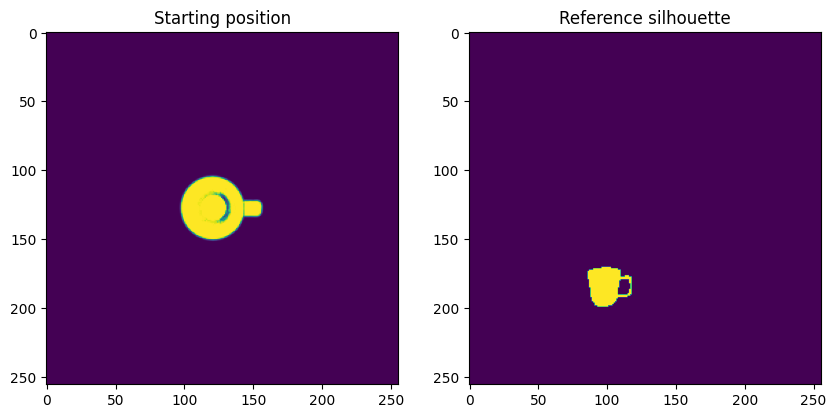

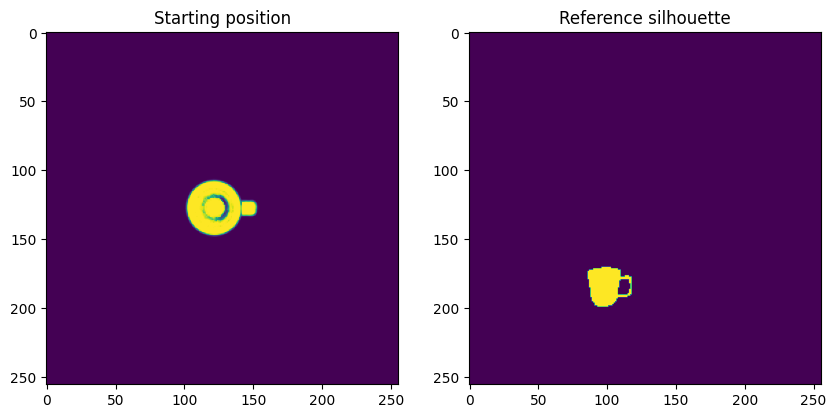

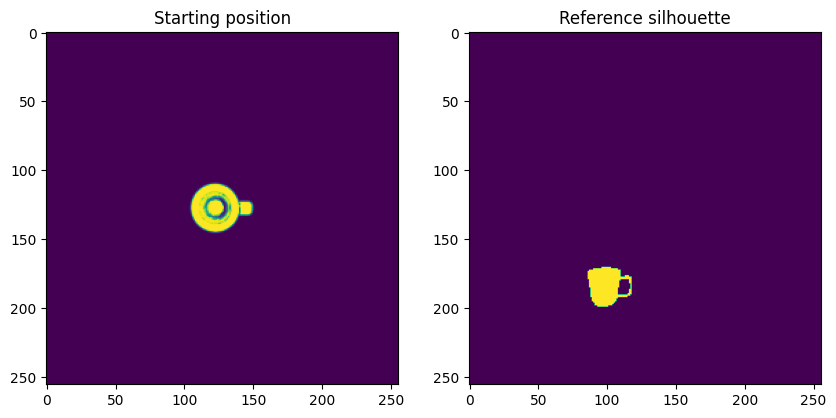

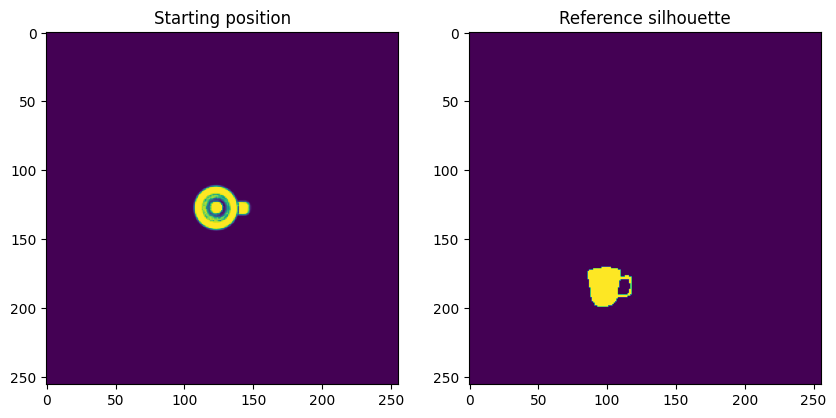

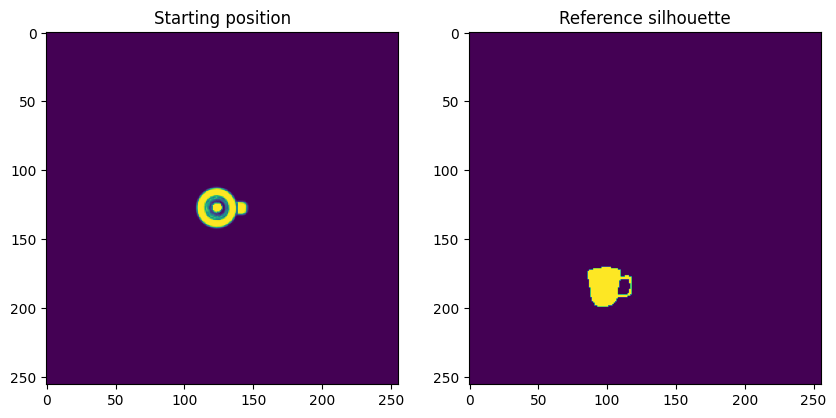

In [ ]:
# 我们将定期保存图像并将其合成为GIF动图。
import transformers
filename_output = "./teapot_optimization_demo.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)
# 我们将定期保存图像并将其合成为GIF动图.
filename_output = "./teapot_optimization_demo.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

for lll in [[0,  0, 0.65], [-0,  0, 0.75], [-0,  0, 0.85], [0,  0, 0.95], [-0,  0, 1.05]]:
    # 使用渲染器/网格和参考图像初始化模型
    model = Model(meshes=teapot_mesh, renderer=silhouette_renderer, image_ref=image_ref, cam_pos_init=lll).to(device)

    # 创建优化器,这里采用Adam算法并传入模型参数
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    scheduler = transformers.get_cosine_schedule_with_warmup(
                    optimizer=optimizer,
                    num_warmup_steps=20,
                    num_training_steps=200,
                    num_cycles=0.5,
                    last_epoch=-1,
                )
    plt.figure(figsize=(10, 10))

    _, image_init = model()
    plt.subplot(1, 2, 1)
    plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
    plt.grid(False)
    plt.title("Starting position")

    plt.subplot(1, 2, 2)
    plt.imshow(model.image_ref.cpu().numpy().squeeze())
    plt.grid(False)
    plt.title("Reference silhouette")
    plt.pause(0.001)  # 刷新输出
    

### Visualize the starting position and the reference position

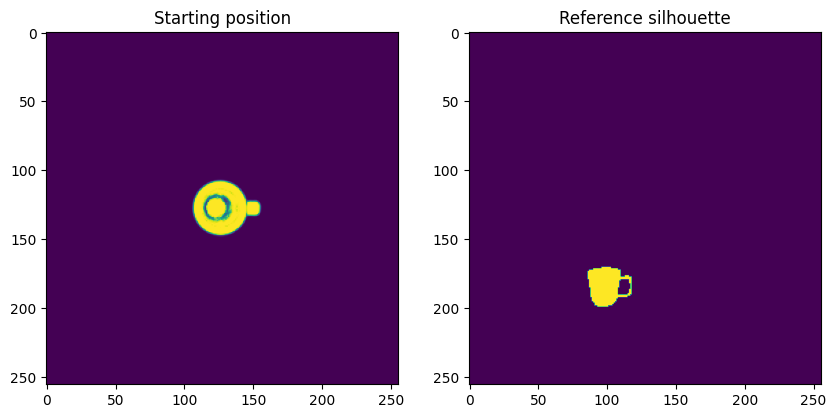

In [171]:
plt.figure(figsize=(10, 10))

_, image_init = model()
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference silhouette");


## 4. Run the optimization 

We run several iterations of the forward and backward pass and save outputs every 10 iterations. When this has finished take a look at `./teapot_optimization_demo.gif` for a cool gif of the optimization process!

  0%|          | 0/200 [00:00<?, ?it/s]

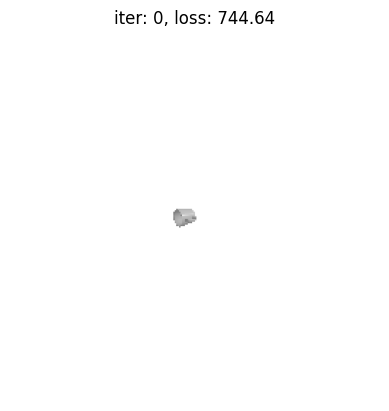

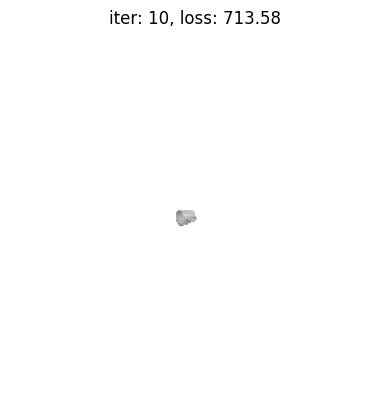

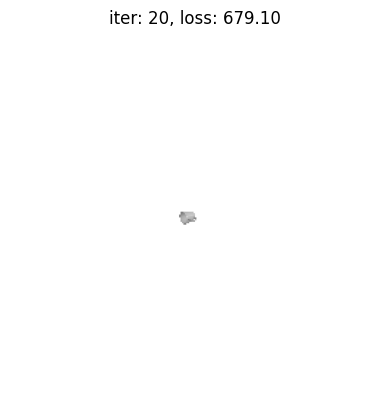

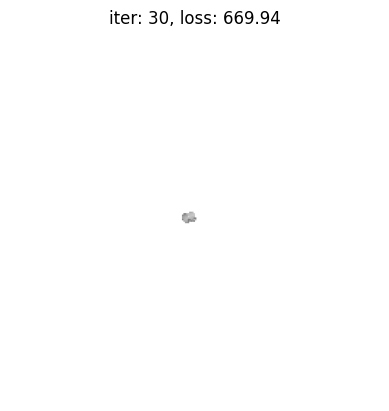

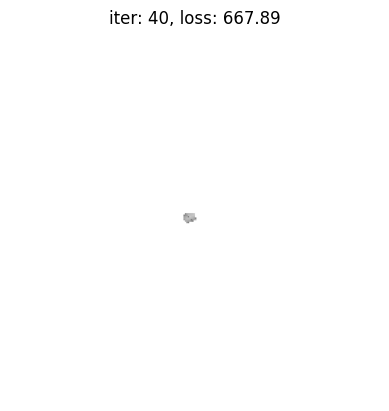

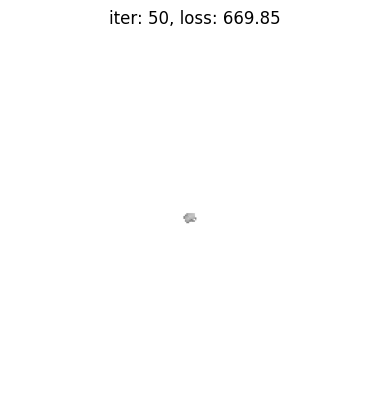

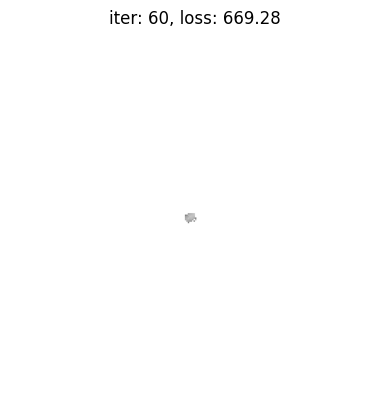

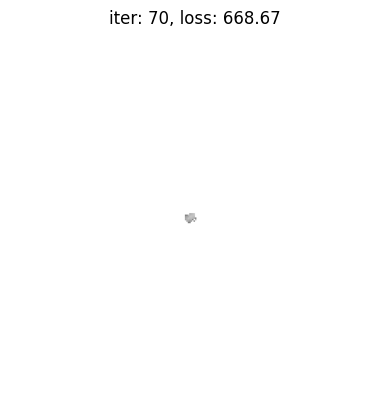

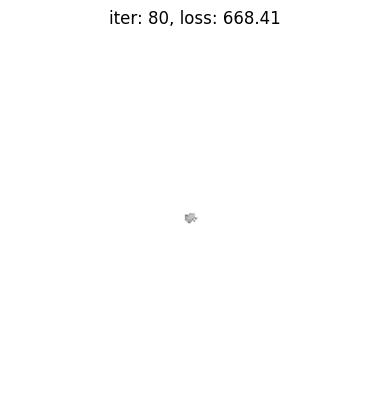

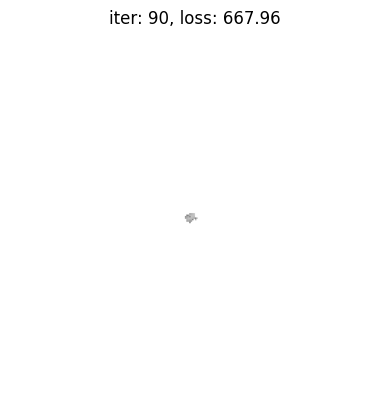

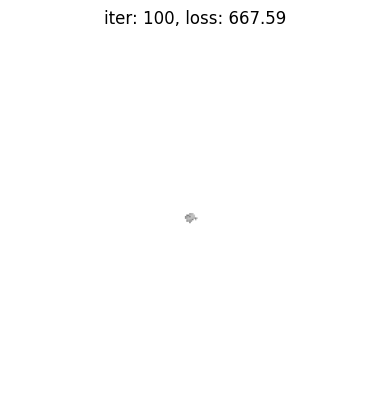

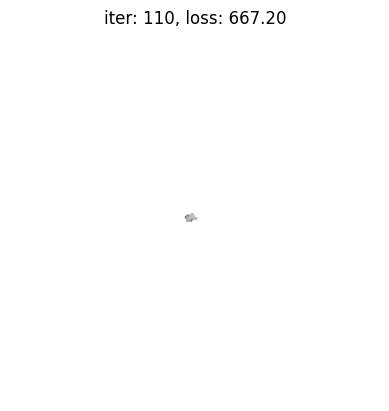

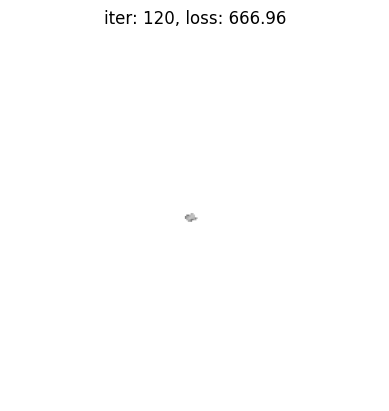

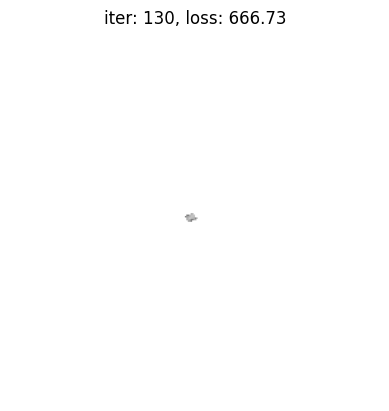

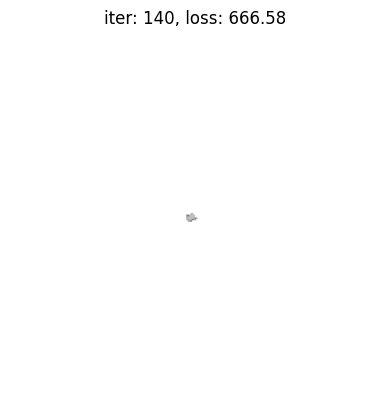

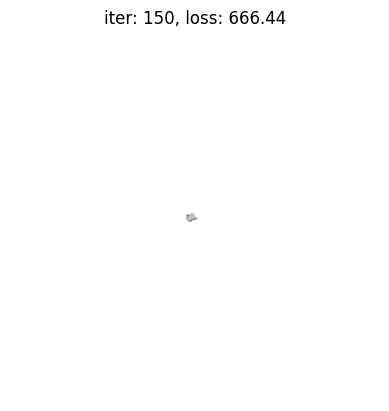

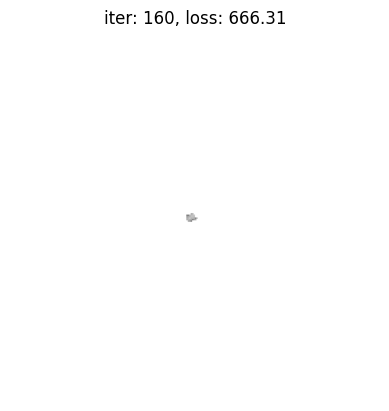

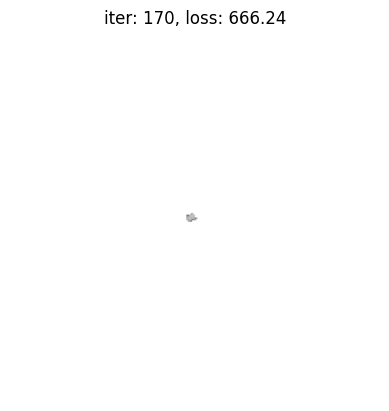

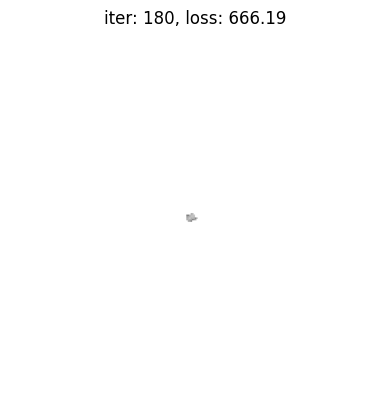

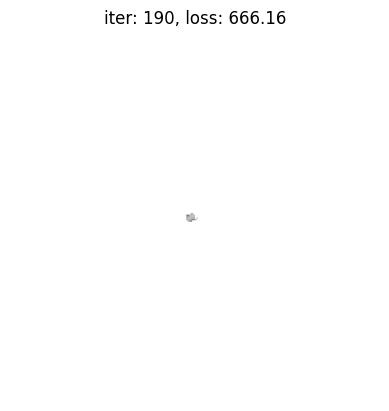

In [129]:
loop = tqdm(range(200))
loss_list=[]
for i in loop:
    optimizer.step()
    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    scheduler.step()
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    loss_list.append(loss.data)
    # if loss.item() < 200:
    #     break
    
    # Save outputs to create a GIF. 
    if i % 10 == 0:
        R = look_at_rotation(model.camera_position[None, :], device=model.device)
        T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)
        
        plt.figure()
        plt.imshow(image[..., :3])
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.axis("off")
    
writer.close()

## 5. Conclusion 

In this tutorial we learnt how to **load** a mesh from an obj file, initialize a PyTorch3D datastructure called **Meshes**, set up an **Renderer** consisting of a **Rasterizer** and a **Shader**, set up an optimization loop including a **Model** and a **loss function**, and run  the optimization. 